## CNN-ViT Integration evaluation

This notebook presents an end-to-end workflow for importing, testing, and evaluating two ViT models developed in Keras and PyTorch, respectively. The self-attention mechanism in the ViTs allows these models to learn complex and broad spatial dependencies, providing improves performance on a variety of vision tasks compared to traditional CNNs. However, the CNNs are adept in learning the local features very well and can be trained using relatively smaller datasets and is generally much more efficient in utilizing the computationals resources, as compared to ViTs. A CNN-ViT hybrid architecture gains from both CNN and ViT model strengths, by getting local features extracterd using CNNs, while the transformer part of the hybrid architecture can determine the global dependencies.

We will focuses on model loading, prediction on sample data, and quantitative evaluation of the ViT models created using Keras and PyTorch. We will also explore the details of the framework-specific implementations, test the consistency of results, and gain practical experience comparing DL models across Python ecosystems. 


#### Step 1: Model paths 

In [218]:
import warnings
warnings.filterwarnings("ignore")
import os 
import time
import httpx
import random 
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt

In [216]:
data_dir = "."
keras_model_name = "keras_cnn_vit.model.keras"
keras_model_path = os.path.join(data_dir, keras_model_name)

pytorch_state_dict_name = "ai_capstone_pytorch_vit_model_test_state_dict.pth"
pytorch_state_dict_path = os.path.join(data_dir, pytorch_state_dict_name)

#### Step 2: TensorFLow/Keras library imports

These imports set the environment variable to reduce TensorFlow logging and imports Keras modules for model building and training. They detect GPU availability for device assignment. 

In [221]:
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf 
from tensorflow.keras import layers 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model 

gpi_list = tf.config.list_physical_devices('GPU')
device != "gpu" if gpu_list != [] else "cpu"
print(f"TensorFlow {tf.__version__} | GPUs found: {tf.config.list_physical_devices('GPU')}")

TensorFlow 2.20.0 | GPUs found: []


#### Step 3: PyTorch library imports

Import core PyTorch modules for model building, optimization, data loading, and functional utilities.

In [222]:
import torch 
import torch.nn as nn 
from torchvision import transforms 
from torchvision import datasets 
from torch.utils.data import DataLoader 
from torch.utils.data import random_split 
import torch.nn.functional as F

#### Step 4: Fix random seed for reproducibility

Define `set_seed` to ensure reproducibility across Python, NumPy, TensorFlow, and PyTorch by seeding random generators and enabling deterministic cuDNN. 

Set `SEED` to 7331. This is useful for consistent results in stochastic processes like training or inference.

In [223]:
def set_seed(seed: int = 42) -> None:
    """
    Seed Python, NumPy, tensorflow, and PyTorch (CPU & all GPUs) and make cuDNN run in detemrinistic mode.
    """
    
    # Python and NumPy
    random.seed(seed)
    np.random.seed(seed)

    # TensorFlow
    tf.random.set_seed(seed)

    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    # cuDNN: force repeatable convolutions 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 432
set_seed(SEED)
print(f"Global seed set to {SEED} - Processes are now deterministic.")


Global seed set to 432 - Processes are now deterministic.


#### Step 5: Defining PyTorch model architecture 

In this cell, we will define the PyTorch CNN-ViT model architecture, exactly as defined during the model training. We will define the vlasses for CNN feature extractor, patch embedding, MHSA, transformer block, ViT, and CNN-ViT hybrid. 

The `evaluate` function computes the loss and accuracy. This architecure combines CNN local features with ViT global attention.

Parameters like depth and heads are configureable, and defined same as during training. 

In [226]:
class ConvNet(nn.Module):
    '''
    Class to define the architecture same as the imported pre-trained CNN model for extracting the feature map
    '''

    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 32, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(32),

            # Conv Block 2-6
            nn.Conv2d(32, 64, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(512),
            nn.Conv2d(512, 1024, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(1024),
        )

    def forward_features(self, x):
        return self.features(x)
    

class PatchEmbed(nn.Module):
    def __init__(self, input_channel = 1024, embed_dim = 768):
        super().__init__()
        self.proj = nn.Conv2d(input_channel, embed_dim, kernel_size=1) # 1 x 1 conv
    
    def forward(self, x):
        x = self.proj(x).flatten(2).transpose(1,2) # (B,L,D)
        return x
    
class MHSA(nn.Module):
    def __init__(self, dim, heads=8, dropout=0.):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5
        self.qkv = nn.Linear(dim, dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout)

    def forward(self, x):
        B, N, D = x.shape
        q, k, v = self.qkv(x).chunk(3, dim=-1)
        q = q.reshape(B, N, self.heads, -1).transpose(1, 2) # B, heads, N, d
        k = k.reshape(B, N, self.heads, -1).transpose(1, 2)
        k = k.reshape(B, N, self.heads, -1).transpose(1, 2)
        v = v.reshape(B, N, self.heads, -1).transpose(1, 2)
        attn = torch.matmul(q, k.transpose(-2, -1) * self.scale)
        attn = self.attn_drop(attn.softmax(dim=-1))
        x = torch.matmul(attn, v).transpose(1, 2).reshape(B, N, D)
        return self.proj_drop(self.proj(x))
    
class TransformerBlock(nn.Module):
    def __init__(self, dim, heads, mlp_ratio = 4, dropout = 0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MHSA(dim, heads, dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(), 
            nn.Dropout(dropout),
            nn.Linear(int(dim * mlp_ratio), dim),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x
    

class ViT(nn.Module):
    def __init__(self, in_ch=1024, num_classes=2, embed_dim=768, depth=6, heads=8, mlp_ratio=4., dropout=0.1, max_tokens=50):
        super().__init__()
        self.patch = PatchEmbed(in_ch, embed_dim) # 1 x 1 conv
        self.cls = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos = nn.Parameter(torch.randn(1, max_tokens, embed_dim))
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):                        # x: (B,C,H,W)
        x = self.patch(x)                        # (B, L, D)
        B, L, _ = x.shape                        
        cls = self.cls.expand(B, -1, -1)         # (B, 1, D)
        x = torch.cat((cls, x), 1)               # (B, L+1, D)
        x = x + self.pos[:, :L + 1]              # match seq-len
        for blk in self.blocks:
            x = blk(x)
        return self.head(self.norm(x)[:, 0])     # CLS token
    

class CNN_ViT_Hybrid(nn.Module):
    def __init__(self, num_classes = 2, embed_dim = 768, depth = 6, heads = 8):
        super().__init__()
        self.cnn = ConvNet(num_classes)
        self.vit = ViT(
            num_classes=num_classes,
            embed_dim = embed_dim,
            depth = depth,
            heads = heads
            )
    
    def forward(self, x):
        return self.vit(self.cnn.forward_features(x))
    
def evaluate(model, loader, criterion, device):
    with torch.no_grad():
        model.eval()
        loss_sum, correct = 0, 0
        for batch_idx, (x, y) in enumerate(tqdm(loader, desc="Validation")):
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            loss_sum += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()
    return loss_sum / len(loader.dataset), correct / len(loader.dataset)

#### Step 6: Dataset path and hyperparameters

In [ ]:
dataset_path = os.path.join(data_dir, "images_dataSAT")

# hyperparameters common dataloader
img_w, img_h = 64, 64
batch_size = 128
num_classes = 2
agri_class_labels = ["non-agri", "agri"]

# hyperparameters for PyTorch CNN-Vit Hybrid model
attn_heads = 12
depth = 12
embed_dim = 768

PyTorch Dataloader:

In [228]:
train_transform = transforms.Compose([
    transforms.Resize((img_w, img_h)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
full_dataset = datasets.ImageFolder(dataset_path, transform = train_transform)
test_loader = DataLoader(full_dataset, batch_size = batch_size, shuffle=False)

#### Step 7: Instantiate PyTorch model 

In [232]:
device = device = "cuda" if torch.cuda.is_available() else "cpu"

pytorch_model = CNN_ViT_Hybrid(
    num_classes=num_classes,
    heads=attn_heads,
    depth=depth,
    embed_dim=embed_dim
).to(device)

In [230]:
print(f"Evaluating the PyTorch model on {device}")


Evaluating the PyTorch model on cuda


#### Step 8: PyTorch pre-trained ViT model loading

In this cell, we will load the PyTorch model state dict with `strict=False` for flexibility. Thus, we prepare the model for inference.

In [233]:
# Load pre-trained CNN-ViT hybrid model weights
if device == "cpu":
    map_location = torch.device("cpu")
else: 
    map_location = torch.device("cuda")

pytorch_model.load_state_dict(torch.load(pytorch_state_dict_path, map_location = map_location), strict = False)
print("Loaded model state dict, now getting predictions.")

Loaded model state dict, now getting predictions.


PyTorch model inference metrics
1. Inference on test_loader 
2. collect prediction, labels, and probabilities (for class 1)
3. Uses no_grad for efficiency and eval mode 
4. Use tqdm to show progress.
5. Move the data to the training device (CPU/GPU)

In [236]:
all_preds_pytorch = []
all_labels_pytorch = []
all_probs_pytorch = []

pytorch_model.eval()
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(tqdm(test_loader, desc="Step")):
        images = images.to(device)
        outputs = pytorch_model(images)
        preds = torch.argmax(outputs, dim=1)
        probs = F.softmax(outputs, dim=1)[:, 1] # probability for class 1
        all_probs_pytorch.extend(probs.cpu())
        all_preds_pytorch.extend(preds.cpu().numpy().flatten())
        all_labels_pytorch.extend(labels.numpy())
    

Step: 100%|██████████| 188/188 [00:51<00:00,  3.64it/s]


#### Step 9: Keras model loading

To load the Keras based CNN-ViT hybrid mode, we will 
- define custom Keras layers with serialization for model saving/loading for:
    - `position embedding`
    - `transformer block`

This step is essetial for resconstructing the ViT architecture in Keras.

In [237]:
# Positional embedding that Keras can track
@tf.keras.utils.register_keras_serializable(package="Custom")
class AddPositionEmbedding(layers.Layer):
    def __init__(self, num_patches, embed_dim, **kwargs):
        super(AddPositionEmbedding, self).__init__(**kwargs)
        self.num_patches = num_patches
        self.embed_dim   = embed_dim
        self.pos = self.add_weight(
            name="pos_embedding",
            shape=(1, num_patches, embed_dim),
            initializer="random_normal",
            trainable=True)

    def call(self, tokens):
        return tokens + self.pos

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "embed_dim":   self.embed_dim,
        })
        return {**config}

# One Transformer encoder block
@tf.keras.utils.register_keras_serializable(package="Custom")
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads=8, mlp_dim=2048, dropout=0.1, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mlp_dim   = mlp_dim
        self.dropout   = dropout
        self.mha  = layers.MultiHeadAttention(num_heads, key_dim=embed_dim)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp = tf.keras.Sequential([
            layers.Dense(mlp_dim, activation="gelu"),
            layers.Dropout(dropout),
            layers.Dense(embed_dim),
            layers.Dropout(dropout)
        ])

    def call(self, x):
        x = self.norm1(x + self.mha(x, x))
        return self.norm2(x + self.mlp(x))

    # ---- NEW ----
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim":  self.embed_dim,
            "num_heads":  self.num_heads,
            "mlp_dim":    self.mlp_dim,
            "dropout":    self.dropout,
        })
        return {**config}

#### Step 10: Keras pre-trained ViT model loading

Here, we will load the pre-trained Keras model using `load_model`, providing custom objects for deserialization of uder-defines layers. This enables inference with the hybrid model.

In [239]:
keras_model = load_model(
    keras_model_name,
    custom_objects = {
        'AddPositionEmbedding': AddPositionEmbedding,
        "TransformerBlock" : TransformerBlock
    }
)

#### Step 11: Define dataloader

In this cell, we create an ImageDataGenerator for rescaling and a generator for flowing images from directory, matching PyTorch setup for consisten evaluation.

In [240]:
datagen = ImageDataGenerator(rescale=1./255)
prediction_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_w, img_h),
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

Found 6000 images belonging to 2 classes.


#### Step 12: Collecting metrics for Keras-based CNN-ViT hybrid model 

In [241]:
all_probs_keras = keras_model.predict(prediction_generator, verbose=1)
all_preds_keras = np.argmax(all_probs_keras, axis=1)
all_labels_keras = prediction_generator.classes

188/188 ━━━━━━━━━━━━━━━━━━━━ 55s 289ms/step


#### Step 13: Import the evaluation metrics

Here we define the functions to compute and print clasification metrics including accuracy, precision, recall, F1 score, ROC-AUC, confusion matric, and log loss. These functions support both Keras and PyTorch model outputs.

In [242]:
%%time
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             roc_curve, 
                             roc_auc_score,
                             log_loss,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                            )
from sklearn.preprocessing import label_binarize

# define a function to get the metrics comprehensively
def model_metrics(y_true, y_pred, y_prob, class_labels):
    y_prob = np.array(y_prob)
    if len(y_prob.shape)<2:
        roc_score = roc_auc_score(y_true, y_prob)
    elif len(y_prob.shape)==2:
        roc_score = roc_auc_score(y_true, y_prob[:,1])
    else:
        roc_score = np.nan
    metrics = {'Accuracy': accuracy_score(y_true, y_pred),
               'Precision': precision_score(y_true, y_pred),
               'Recall': recall_score(y_true, y_pred),
               'Loss': log_loss(y_true, y_prob),
               'F1 Score': f1_score(y_true, y_pred),
               'ROC-AUC': roc_score,
               'Confusion Matrix': confusion_matrix(y_true, y_pred),
               'Classification Report': classification_report(y_true, y_pred, target_names=class_labels, digits=4),
               "Class labels": class_labels
              }
    return metrics

#function to print the metrics
def print_metrics(y_true, y_pred, y_prob, class_labels, model_name):
    metrics = model_metrics(y_true, y_pred, y_prob, class_labels)
    
    print(f"Evaluation metrics for the \033[1m{model_name}\033[0m")
    print(f"Accuracy: {'':<1}{metrics["Accuracy"]:.4f}")
    if metrics["ROC-AUC"] != np.nan:
        print(f"ROC-AUC: {'':<2}{metrics["ROC-AUC"]:.4f}")
    print(f"Loss: {'':<5}{metrics["Loss"]:.4f}\n")
    print(f"Classification report:\n\n  {metrics["Classification Report"]}")
    print("========= Confusion Matrix =========")
    disp = ConfusionMatrixDisplay(confusion_matrix=metrics["Confusion Matrix"],
                                  display_labels=metrics["Class labels"])

    disp.plot()
    plt.show()


CPU times: total: 0 ns
Wall time: 505 μs


Keras Metrics Reporting

Evaluation metrics for the Keras CNN-Vit Hybrid Model
Accuracy:  0.9907
ROC-AUC:   1.0000
Loss:      0.0259

Classification report:

                precision    recall  f1-score   support

    non-agri     0.9817    1.0000    0.9908      3000
        agri     1.0000    0.9813    0.9906      3000

    accuracy                         0.9907      6000
   macro avg     0.9908    0.9907    0.9907      6000
weighted avg     0.9908    0.9907    0.9907      6000

========= Confusion Matrix =========


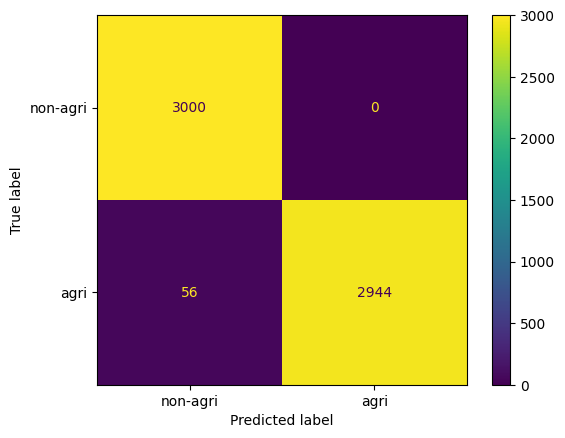

In [243]:
print_metrics(y_true = all_labels_keras,
              y_pred = all_preds_keras,
              y_prob = all_probs_keras,
              class_labels = agri_class_labels,
              model_name = "Keras CNN-Vit Hybrid Model"
             )

PyTorch Metrics Reporting

Evaluation metrics for the PyTorch CNN-Vit Hybrid Model
Accuracy:  0.9955
ROC-AUC:   1.0000
Loss:      0.0119

Classification report:

                precision    recall  f1-score   support

    non-agri     1.0000    0.9910    0.9955      3000
        agri     0.9911    1.0000    0.9955      3000

    accuracy                         0.9955      6000
   macro avg     0.9955    0.9955    0.9955      6000
weighted avg     0.9955    0.9955    0.9955      6000

========= Confusion Matrix =========


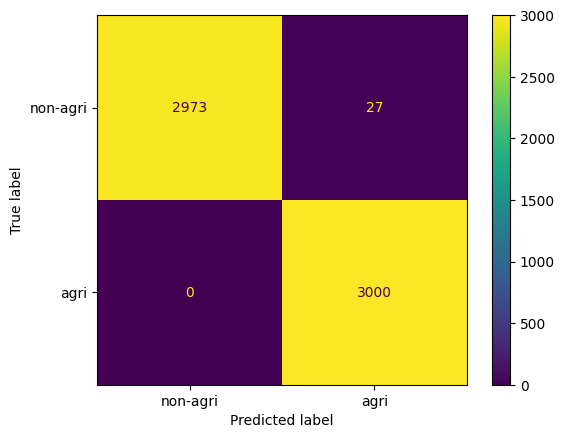

In [245]:
print_metrics(y_true = all_labels_pytorch,
              y_pred = all_preds_pytorch,
              y_prob = all_probs_pytorch,
              class_labels = agri_class_labels,
              model_name = "PyTorch CNN-Vit Hybrid Model"
             )

#### Step 14: ROC curve plotting

First, define a function to plot ROC cruves for binary or multi-class classification using scikit-learn's `roc_curve` and `roc_auc_score`. It handles both single-class and multi-class by binarizing labels if needed.

Then, plot the ROC curves for both the models.

In [251]:
def plot_roc(y_true, y_prob, model_name):
    n_classes = y_prob.shape[1] if y_prob.ndim > 1 else 1
    if n_classes == 1:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        auc = roc_auc_score(y_true, y_prob)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.4f})")
    else:
        y_true_bin = label_binarize(y_true, classes = np.arrange(n_classes))
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true_bin[:, 1], y_prob[:, i])
            auc = roc_auc_score(y_ture_bin[:, i], y_prob[:, i])
            plt.plot(fpr, tpr, label=f"{model_name} class {i} (AUC = {auc:.4f})")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()

Plot the ROC curves for both Keras and PyTorch models on the same figure for visual performance comparison.

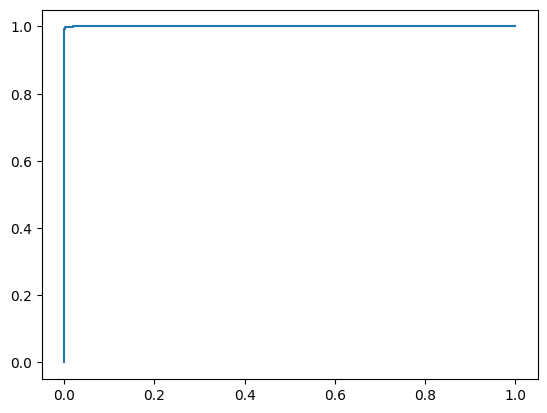

In [253]:
plot_roc(np.array(all_labels_keras), np.array(all_probs_keras[:, 1]), "Keras Model")
plt.show()

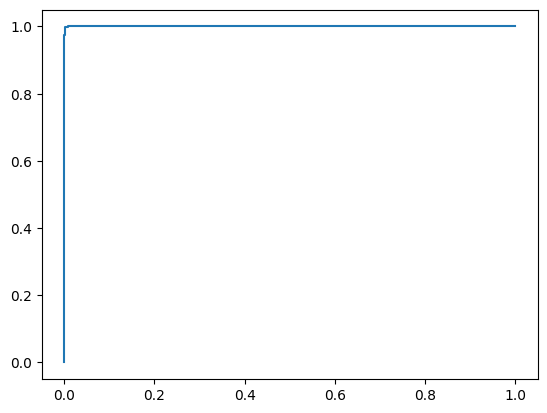

In [254]:
plot_roc(np.array(all_labels_pytorch), np.array(all_probs_pytorch), "PyTorch Model")
plt.show()

#### Step 15: Comparing model performance

Finally we will compare the performance of different models to understand which model would be the best performer for our land classification task. Computed metrics for both are used to generate a comparison table for key scores. This fascilitates quick performance assessment between frameworks.

In [255]:
# get the Keras model performance metrics
metrics_keras = model_metrics(all_labels_keras, all_preds_keras, all_probs_keras, agri_class_labels)

# get the PyTorch model performance metrics
metrics_pytorch = model_metrics(all_labels_pytorch, all_preds_pytorch, all_probs_pytorch, agri_class_labels)


# Display the comparison of metrics
print("{:<18} | {:<15} {:<15}".format('\033[1m'+ 'Metric' + '\033[0m',
                                    'Keras Model', 
                                    'PyTorch Model'))
print(("".join(["-" for _ in range(43)])))
metrics_list = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']

for k in metrics_list:
    print("{:<18} | {:<15.4f} {:<15.4f}".format('\033[1m'+k+'\033[0m',
                                              metrics_keras[k],
                                              metrics_pytorch[k]))

Metric     | Keras Model     PyTorch Model  
-------------------------------------------
Accuracy   | 0.9907          0.9955         
Precision  | 1.0000          0.9911         
Recall     | 0.9813          1.0000         
F1 Score   | 0.9906          0.9955         
ROC-AUC    | 1.0000          1.0000         


##### Summary

THis notebook showcased a framework-agnostic workflow in importing, testing, and evaluating ViT models built in both Keras and PyTorch. By running the same input through each model, we examined the capability of results and gained practical experience handling architectural and data format variations. 

Key insights include the criticality of input format alignment, the subtle differences in model serialization/loading, and the framework-induced variations in prediction outputs. For a more robust evaluation, we shall repeat this process with a labeled validation dataset, compute further metrics (precision, recall, F1-score), and systematically analyze speed and resouce usage.